In [1]:
import gc
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import seed

from tensorflow import set_random_seed

from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
seed(639)
set_random_seed(5944)

In [4]:

print(os.listdir("../input"))

['unarch', 'lanl-features.zip', 'test.zip', 'sample_submission.csv', 'train.csv.zip', 'test', 'train']


In [5]:
float_data = pd.read_csv("../input/train/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [60]:
def extract_features(z):
     return np.c_[
         z.mean(axis=1),
         #np.transpose(np.percentile(np.abs(z), q=[0, 50, 75, 100], axis=1)),
         z.std(axis=1),
         #z.kurtosis(axis=1),
         #z.pow(axis=1)
         np.sqrt(np.abs(z)).mean(axis=1),
         np.sqrt(np.abs(z)).std(axis=1),
         #np.prod(np.sqrt(np.abs(z)))
         #np.cos(z).mean(axis=1),
         #np.log(np.abs(z)).mean(axis=1)
     ]

In [7]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    # ORIGINAL: I changed this becuase I got an No OpKernel was registered to support Op 'CudnnRNN' error
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # MY CHANGE: This doesn't fix things, I get the same errors
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1).astype(np.float32) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]

In [61]:
# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)

Our RNN is based on 12 features


In [9]:
 
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data,min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets    

In [62]:
batch_size = 64

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
# train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)

In [63]:
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_6 (CuDNNGRU)       (None, 48)                8928      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                490       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 9,429
Trainable params: 9,429
Non-trainable params: 0
_________________________________________________________________


In [64]:
%%time
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=30,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

Epoch 1/30
1000/1000 [==============================] - 173s 173ms/step - loss: 2.5647 - val_loss: 1.8682
Epoch 2/30
1000/1000 [==============================] - 171s 171ms/step - loss: 2.1408 - val_loss: 1.8078
Epoch 3/30
1000/1000 [==============================] - 172s 172ms/step - loss: 2.1503 - val_loss: 1.9401
Epoch 4/30
1000/1000 [==============================] - 175s 175ms/step - loss: 2.1204 - val_loss: 2.0239
Epoch 5/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.1167 - val_loss: 1.8428
Epoch 6/30
1000/1000 [==============================] - 176s 176ms/step - loss: 2.1198 - val_loss: 1.9124
Epoch 7/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.1093 - val_loss: 1.8500
Epoch 8/30
1000/1000 [==============================] - 170s 170ms/step - loss: 2.0925 - val_loss: 1.8990
Epoch 9/30
1000/1000 [==============================] - 171s 171ms/step - loss: 2.0940 - val_loss: 1.9609
Epoch 10/30
1000/1000 [=======================

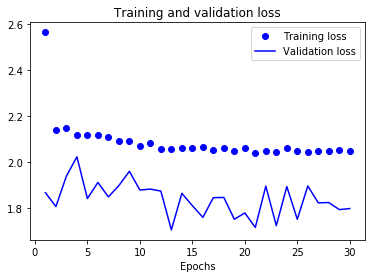

In [65]:
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [66]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

In [67]:
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

100%|██████████| 2624/2624 [00:52<00:00, 49.86it/s]


,time_to_failure
seg_id,
seg_00030f,2.674795
seg_0012b5,5.073872
seg_00184e,4.923174
seg_003339,8.162327
seg_0042cc,6.441953


In [68]:
submission.to_csv('submission-2019-05-25-5-simply-mean-and-std-and-sqrt-mean-and-std.csv')

In [ ]:
pd.read_csv?

In [ ]:
train_gen.__next__()

In [ ]:
gc.collect()

In [ ]:
Simply mean and std and cos std
Epoch 1/30
1000/1000 [==============================] - 248s 248ms/step - loss: 2.9901 - val_loss: 1.9164
Epoch 2/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.1430 - val_loss: 1.9244
Epoch 3/30
1000/1000 [==============================] - 252s 252ms/step - loss: 2.1159 - val_loss: 1.9459
Epoch 4/30
1000/1000 [==============================] - 246s 246ms/step - loss: 2.1170 - val_loss: 1.8193
Epoch 5/30
1000/1000 [==============================] - 246s 246ms/step - loss: 2.1232 - val_loss: 1.8641
Epoch 6/30
1000/1000 [==============================] - 242s 242ms/step - loss: 2.1084 - val_loss: 1.8563
Epoch 7/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.1159 - val_loss: 1.8426
Epoch 8/30
1000/1000 [==============================] - 254s 254ms/step - loss: 2.1002 - val_loss: 1.8846
Epoch 9/30
1000/1000 [==============================] - 252s 252ms/step - loss: 2.0990 - val_loss: 1.9181
Epoch 10/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.0976 - val_loss: 1.8273
Epoch 11/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.0807 - val_loss: 1.8851
Epoch 12/30
1000/1000 [==============================] - 248s 248ms/step - loss: 2.0681 - val_loss: 1.7579
Epoch 13/30
1000/1000 [==============================] - 244s 244ms/step - loss: 2.0666 - val_loss: 1.8162
Epoch 14/30
1000/1000 [==============================] - 244s 244ms/step - loss: 2.0657 - val_loss: 1.8746
Epoch 15/30
1000/1000 [==============================] - 248s 248ms/step - loss: 2.0517 - val_loss: 1.8078
Epoch 16/30
1000/1000 [==============================] - 249s 249ms/step - loss: 2.0486 - val_loss: 1.8673
Epoch 17/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.0425 - val_loss: 1.8176
Epoch 18/30
1000/1000 [==============================] - 247s 247ms/step - loss: 2.0564 - val_loss: 1.7874
Epoch 19/30
1000/1000 [==============================] - 254s 254ms/step - loss: 2.0357 - val_loss: 1.7595
Epoch 20/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.0284 - val_loss: 1.7087
Epoch 21/30
1000/1000 [==============================] - 250s 250ms/step - loss: 2.0457 - val_loss: 1.7775
Epoch 22/30
1000/1000 [==============================] - 249s 249ms/step - loss: 2.0421 - val_loss: 1.8485
Epoch 23/30
1000/1000 [==============================] - 252s 252ms/step - loss: 2.0524 - val_loss: 1.8584
Epoch 24/30
1000/1000 [==============================] - 252s 252ms/step - loss: 2.0299 - val_loss: 1.8553
Epoch 25/30
1000/1000 [==============================] - 252s 252ms/step - loss: 2.0478 - val_loss: 1.8547
Epoch 26/30
1000/1000 [==============================] - 249s 249ms/step - loss: 2.0386 - val_loss: 1.8735
Epoch 27/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.0407 - val_loss: 1.8122
Epoch 28/30
1000/1000 [==============================] - 252s 252ms/step - loss: 2.0359 - val_loss: 1.9260
Epoch 29/30
1000/1000 [==============================] - 255s 255ms/step - loss: 2.0335 - val_loss: 1.8426
Epoch 30/30
1000/1000 [==============================] - 253s 253ms/step - loss: 2.0313 - val_loss: 1.7814
CPU times: user 2h 15min 42s, sys: 1min 26s, total: 2h 17min 9s
Wall time: 2h 5min 9s

In [ ]:
Simply mean and std
Epoch 1/30
1000/1000 [==============================] - 92s 92ms/step - loss: 2.4773 - val_loss: 1.8584
Epoch 2/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.1377 - val_loss: 1.9840
Epoch 3/30
1000/1000 [==============================] - 93s 93ms/step - loss: 2.1262 - val_loss: 1.8766
Epoch 4/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.1176 - val_loss: 2.0576
Epoch 5/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.1047 - val_loss: 1.9017
Epoch 6/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.1160 - val_loss: 1.8693
Epoch 7/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.1052 - val_loss: 1.8665
Epoch 8/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.1022 - val_loss: 1.7413
Epoch 9/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0809 - val_loss: 1.8707
Epoch 10/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0681 - val_loss: 1.8087
Epoch 11/30
1000/1000 [==============================] - 94s 94ms/step - loss: 2.0653 - val_loss: 1.8031
Epoch 12/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.0618 - val_loss: 1.8276
Epoch 13/30
1000/1000 [==============================] - 94s 94ms/step - loss: 2.0504 - val_loss: 1.6156
Epoch 14/30
1000/1000 [==============================] - 94s 94ms/step - loss: 2.0455 - val_loss: 1.8251
Epoch 15/30
1000/1000 [==============================] - 93s 93ms/step - loss: 2.0601 - val_loss: 1.8663
Epoch 16/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0478 - val_loss: 1.7238
Epoch 17/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.0511 - val_loss: 1.8351
Epoch 18/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.0514 - val_loss: 1.8227
Epoch 19/30
1000/1000 [==============================] - 94s 94ms/step - loss: 2.0538 - val_loss: 1.8032
Epoch 20/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.0517 - val_loss: 1.8739
Epoch 21/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0480 - val_loss: 1.7660
Epoch 22/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0491 - val_loss: 1.7206
Epoch 23/30
1000/1000 [==============================] - 93s 93ms/step - loss: 2.0429 - val_loss: 1.9183
Epoch 24/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0418 - val_loss: 1.7688
Epoch 25/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0469 - val_loss: 1.7554
Epoch 26/30
1000/1000 [==============================] - 90s 90ms/step - loss: 2.0562 - val_loss: 1.6820
Epoch 27/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.0588 - val_loss: 1.7710
Epoch 28/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.0381 - val_loss: 1.8879
Epoch 29/30
1000/1000 [==============================] - 92s 92ms/step - loss: 2.0401 - val_loss: 1.8273
Epoch 30/30
1000/1000 [==============================] - 91s 91ms/step - loss: 2.0362 - val_loss: 1.8246
CPU times: user 54min 47s, sys: 1min 19s, total: 56min 6s
Wall time: 45min 36s

In [ ]:
simply mean and std and sqrt mean
Epoch 1/30
1000/1000 [==============================] - 119s 119ms/step - loss: 2.6020 - val_loss: 1.8835
Epoch 2/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.1425 - val_loss: 1.8158
Epoch 3/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.1146 - val_loss: 2.0112
Epoch 4/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.1073 - val_loss: 1.8081
Epoch 5/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.1059 - val_loss: 1.7899
Epoch 6/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.1087 - val_loss: 1.8111
Epoch 7/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.1139 - val_loss: 1.9136
Epoch 8/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0855 - val_loss: 1.9241
Epoch 9/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0827 - val_loss: 1.9298
Epoch 10/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0732 - val_loss: 1.8520
Epoch 11/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0762 - val_loss: 1.8775
Epoch 12/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0617 - val_loss: 1.8242
Epoch 13/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0435 - val_loss: 1.8089
Epoch 14/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0519 - val_loss: 1.6844
Epoch 15/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0479 - val_loss: 1.7952
Epoch 16/30
1000/1000 [==============================] - 122s 122ms/step - loss: 2.0517 - val_loss: 1.8399
Epoch 17/30
1000/1000 [==============================] - 120s 120ms/step - loss: 2.0537 - val_loss: 1.8737
Epoch 18/30
1000/1000 [==============================] - 120s 120ms/step - loss: 2.0388 - val_loss: 1.8788
Epoch 19/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0486 - val_loss: 1.8394
Epoch 20/30
1000/1000 [==============================] - 120s 120ms/step - loss: 2.0551 - val_loss: 1.8790
Epoch 21/30
1000/1000 [==============================] - 120s 120ms/step - loss: 2.0580 - val_loss: 1.8425
Epoch 22/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0423 - val_loss: 1.6663
Epoch 23/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0528 - val_loss: 1.8478
Epoch 24/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0481 - val_loss: 1.9197
Epoch 25/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0478 - val_loss: 1.8522
Epoch 26/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0310 - val_loss: 1.7600
Epoch 27/30
1000/1000 [==============================] - 119s 119ms/step - loss: 2.0462 - val_loss: 1.7277
Epoch 28/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0414 - val_loss: 1.7540
Epoch 29/30
1000/1000 [==============================] - 118s 118ms/step - loss: 2.0317 - val_loss: 1.8865
Epoch 30/30
1000/1000 [==============================] - 117s 117ms/step - loss: 2.0364 - val_loss: 1.7143
CPU times: user 1h 8min 33s, sys: 1min 22s, total: 1h 9min 55s
Wall time: 59min 4s

In [ ]:
simply mean and std and sqrt mean and std
Epoch 1/30
1000/1000 [==============================] - 173s 173ms/step - loss: 2.5647 - val_loss: 1.8682
Epoch 2/30
1000/1000 [==============================] - 171s 171ms/step - loss: 2.1408 - val_loss: 1.8078
Epoch 3/30
1000/1000 [==============================] - 172s 172ms/step - loss: 2.1503 - val_loss: 1.9401
Epoch 4/30
1000/1000 [==============================] - 175s 175ms/step - loss: 2.1204 - val_loss: 2.0239
Epoch 5/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.1167 - val_loss: 1.8428
Epoch 6/30
1000/1000 [==============================] - 176s 176ms/step - loss: 2.1198 - val_loss: 1.9124
Epoch 7/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.1093 - val_loss: 1.8500
Epoch 8/30
1000/1000 [==============================] - 170s 170ms/step - loss: 2.0925 - val_loss: 1.8990
Epoch 9/30
1000/1000 [==============================] - 171s 171ms/step - loss: 2.0940 - val_loss: 1.9609
Epoch 10/30
1000/1000 [==============================] - 172s 172ms/step - loss: 2.0713 - val_loss: 1.8797
Epoch 11/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.0823 - val_loss: 1.8836
Epoch 12/30
1000/1000 [==============================] - 177s 177ms/step - loss: 2.0565 - val_loss: 1.8751
Epoch 13/30
1000/1000 [==============================] - 177s 177ms/step - loss: 2.0569 - val_loss: 1.7065
Epoch 14/30
1000/1000 [==============================] - 176s 176ms/step - loss: 2.0620 - val_loss: 1.8654
Epoch 15/30
1000/1000 [==============================] - 173s 173ms/step - loss: 2.0601 - val_loss: 1.8119
Epoch 16/30
1000/1000 [==============================] - 171s 171ms/step - loss: 2.0681 - val_loss: 1.7609
Epoch 17/30
1000/1000 [==============================] - 171s 171ms/step - loss: 2.0520 - val_loss: 1.8465
Epoch 18/30
1000/1000 [==============================] - 177s 177ms/step - loss: 2.0620 - val_loss: 1.8474
Epoch 19/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.0488 - val_loss: 1.7527
Epoch 20/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.0633 - val_loss: 1.7802
Epoch 21/30
1000/1000 [==============================] - 170s 170ms/step - loss: 2.0398 - val_loss: 1.7175
Epoch 22/30
1000/1000 [==============================] - 170s 170ms/step - loss: 2.0485 - val_loss: 1.8967
Epoch 23/30
1000/1000 [==============================] - 172s 172ms/step - loss: 2.0430 - val_loss: 1.7251
Epoch 24/30
1000/1000 [==============================] - 176s 176ms/step - loss: 2.0632 - val_loss: 1.8947
Epoch 25/30
1000/1000 [==============================] - 177s 177ms/step - loss: 2.0498 - val_loss: 1.7527
Epoch 26/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.0446 - val_loss: 1.8972
Epoch 27/30
1000/1000 [==============================] - 174s 174ms/step - loss: 2.0503 - val_loss: 1.8240
Epoch 28/30
1000/1000 [==============================] - 172s 172ms/step - loss: 2.0489 - val_loss: 1.8254
Epoch 29/30
1000/1000 [==============================] - 172s 172ms/step - loss: 2.0521 - val_loss: 1.7947
Epoch 30/30
1000/1000 [==============================] - 178s 178ms/step - loss: 2.0490 - val_loss: 1.7992
CPU times: user 1h 37min 7s, sys: 1min 31s, total: 1h 38min 39s
Wall time: 1h 27min 9s